In [271]:
import pandas as pd
import os
import importlib
import functools
import time
from multiprocessing import Pool

import cftime
import nc_time_axis
import xarray as xr
import numpy as np
import matplotlib, matplotlib.pyplot as plt, matplotlib.patheffects as pe

import derived
import visualization

importlib.reload(derived);
importlib.reload(visualization);

### Compositing methodology
1. Define TC characteristics
   - model name,
   - experiment name, 
   - year range
   - intensity range (optional)
   - basin name (optional)
2. Use TC characteristics to find corresponding saved TCs in defined directory
3. Define reference point (`reference_timestamp`) for sampling methodology for each TC
   - e.g., relative to LMI, relative to genesis)
4. Define time delta from reference point (i.e., `reference_timestamp + N hours`, `N` is integer)
5. For each TC identified:
   - a. Lazy load TC
   - b. Select at hour `reference_timestamp + N hours`
   - c. Drop all nan values
   - d. Store the selected data

In [51]:
def get_filename_year(filename: str) -> int:
    delimiter_string = 'storm_ID'
    filename_year = int(filename.split(f'{delimiter_string}-')[-1].split('-')[0])
    return filename_year

In [52]:
def get_filename_intensity(filename: str,
                           delimiter_string: str) -> int:
    filename_intensity = int(filename.split(f'{delimiter_string}-')[-1].split('.')[0])
    return filename_intensity

In [53]:
def get_sampling_timestamp(storm: xr.Dataset,
                           reference_point: str='LMI',
                           number_of_offset_hours: int=0,
                           intensity_parameter: str='max_wind') -> cftime._cftime.DatetimeNoLeap:

    ''' Method to obtain the timestamp to sample a TC at. '''

    # Obtain the first timestamp for a TC (assumed to be genesis)
    genesis_timestamp = storm.isel(time=0)['time'].item()
    # Define the identifier used as a reference time for cftime timedelta calculation
    reference_identifier = f'seconds since {genesis_timestamp}'

    # Obtain the reference timestamp (either genesis or LMI)
    if reference_point == 'LMI':
        # Obtain the value of maximum intensity
        maximum_intensity = storm[intensity_parameter].max() if intensity_parameter == 'max_wind' else storm[intensity_parameter].min()
        # Obtain the reference timestamp based on the maximum intensity value
        reference_timestamp = storm.where(storm[intensity_parameter] == maximum_intensity)[intensity_parameter].dropna(dim='time')['time'].item()
    elif reference_point == 'genesis':
        reference_timestamp = genesis_timestamp
        assert number_of_offset_hours >= 0, f'Number of offset hours must be at least 0 when sampling a timestamp relative to storm genesis.'

    # Convert the cftime object to number of seconds since the reference time `reference_identifier`
    reference_timestamp_seconds = cftime.date2num(reference_timestamp, reference_identifier, calendar='noleap')
    # Add the number of offset hours (in units of seconds)
    sampling_timestamp_seconds = reference_timestamp_seconds + number_of_offset_hours*3600
    # Convert this number back to a cftime object
    sampling_timestamp = cftime.num2date(sampling_timestamp_seconds, reference_identifier, calendar='noleap')
    
    return sampling_timestamp

In [54]:
def storm_interpolation_grid_basis_vectors(storm: xr.Dataset,
                                           window_size: int,
                                           diagnostic: bool=False) -> tuple[np.array, np.array]:

    ''' Method to generate uniform interpolation basis vectors for a TC-centered grid. '''

    # Ensure necessary basis vector dimensions are available
    assert ('grid_xt' in storm.dims) and ('grid_yt' in storm.dims)
    # Get differences in grid spacing along each vector
    d_grid_yt = storm['grid_yt'].diff(dim='grid_yt')
    d_grid_xt = storm['grid_xt'].diff(dim='grid_xt')
    # Ensure that the differences are equivalent for all indices to ensure equal spacing
    grid_tolerance = 1e-6
    assert sum(d_grid_xt.diff(dim='grid_xt') < grid_tolerance) == len(d_grid_xt) - 1, 'Grid is irregular along the `grid_xt` axis.'
    assert sum(d_grid_yt.diff(dim='grid_yt') < grid_tolerance) == len(d_grid_yt) - 1, 'Grid is irregular along the `grid_yt` axis.'
    # Get grid spacing along each direction
    dx, dy = d_grid_xt.isel(grid_xt=0).item(), d_grid_yt.isel(grid_yt=0).item()
    # Get the number of grid points in each direction for vector construction
    number_x_grid_points = int(np.around((window_size * 2) / dx))
    number_y_grid_points = int(np.around((window_size * 2) / dy))
    # Construct the basis vectors for Dataset interpolation
    arr_x_interp = np.linspace(-window_size, window_size, number_x_grid_points)
    arr_y_interp = np.linspace(-window_size, window_size, number_y_grid_points)

    if diagnostic:
        print(f'[storm_interpolation_gridpoints]: Number of grid points: x = {number_x_grid_points}, y = {number_y_grid_points}')

    return arr_x_interp, arr_y_interp

In [105]:
def storm_centered_interpolation(storm_sample: xr.Dataset,
                                 sampling_field: str,
                                 window_size: int=10,
                                 number_points_grid_xt: int=40,
                                 number_points_grid_yt: int=32,) -> xr.DataArray:

    # Generate storm-centered coordinates.
    # This will remove dependence on global coordinates and allow for storm-centered compositing.
    arr_x = storm_sample.grid_xt - storm_sample['center_lon']
    arr_y = storm_sample.grid_yt - storm_sample['center_lat']

    # Generate storm ID list to serve as an axis for the storm identifier that will enable xArray-based compositing
    storm_ID = [storm_sample.attrs['storm_id']]
    # Expand dimensions of 2D data for the storm ID axis
    storm_sample_dataset = np.expand_dims(storm_sample[sampling_field].data, axis=0)
    # Storm attributes
    storm_attributes = {key: value for key, value in storm_sample[sampling_field].attrs.items()}
    storm_attributes['max_wind'] = storm_sample['max_wind'].item()
    storm_attributes['min_slp'] = storm_sample['min_slp'].item()
    storm_attributes['time'] = storm_sample['time'].item()
    # Generte the xArray DataArray
    sample = xr.DataArray(data=storm_sample_dataset,
                          dims=['storm_id', 'grid_yt_TC', 'grid_xt_TC'],
                          coords={'grid_xt_TC': (['grid_xt_TC'], arr_x.data),
                                  'grid_yt_TC': (['grid_yt_TC'], arr_y.data),
                                  'storm_id': (['storm_id'], storm_ID)},
                          attrs=storm_attributes)

    # To allow for the combination of different TCs, interpolate the storm-centered coordinates to common axis values based on the window size.
    arr_x_interp, arr_y_interp = storm_interpolation_grid_basis_vectors(storm_sample, window_size)

    # Perform an interpolation from the storm-centered coordinates to the interpolated coordinates
    interpolated_sample = sample.interp(grid_xt_TC=arr_x_interp).interp(grid_yt_TC=arr_y_interp)

    return interpolated_sample

In [56]:
def composite_field_correction(dataset: xr.DataArray,
                               field_name: str):

    factor = 86400 if field_name in ['precip', 'evap', 'p-e'] else 1

    return dataset * factor

In [282]:
def derived_quantities(dataset: xr.Dataset):

    dataset = derived.TC_surface_wind_speed(dataset)
    # dataset = derived.TC_net_lw(dataset)
    # dataset = derived.TC_net_sw(dataset)
    # dataset = derived.TC_temperature_disequilibrium(dataset)

    return dataset

In [274]:
def generate_composite_sample(field_name: str,
                              sampling_reference_point: str,
                              number_of_offset_hours: int,
                              intensity_parameter: str,
                              window_size: int, 
                              pathname: str) -> xr.Dataset:
    ''' Generates a snapshot for a given TC to be used as a sample for composite analysis. Snapshot is based on provided conditions. '''

    # Load the dataset
    storm_dataset = xr.open_dataset(pathname)
    # Get the timestamp that sampling is performed at
    sampling_timestamp = get_sampling_timestamp(storm=storm_dataset, 
                                                reference_point=sampling_reference_point,
                                                number_of_offset_hours=number_of_offset_hours, 
                                                intensity_parameter=intensity_parameter)
    # Remove the empty data belonging to other timestamps
    storm_sample = storm_dataset.sel(time=sampling_timestamp, method='nearest').dropna(dim='grid_xt', how='all').dropna(dim='grid_yt', how='all')
    # Get derived fields
    storm_sample_derived = derived_quantities(storm_sample)
    # Perform grid redefinition and associated spatial interpolation
    storm_sample_interpolated = storm_centered_interpolation(storm_sample_derived, sampling_field=field_name, window_size=window_size)
    
    return storm_sample_interpolated

In [275]:
def generate_composite(model_name: str,
                       experiment_name: str,
                       year_range: tuple[int, int],
                       field_name: str,
                       number_of_offset_hours: int=0,
                       sampling_reference_point: str='LMI',
                       intensity_parameter: str='min_slp',
                       intensity_range: tuple[int|float, int|float]=(0, np.inf),
                       window_size: int=10,
                       troubleshooting: bool=False,
                       parallel: bool=False,
                       statistics: bool=True):

    ''' Method to generate an xArray Dataset with individual TC snapshots at a given number of hours offset from a reference point (genesis or LMI). '''

    # Use TC characteristics to find corresponding saved TCs in defined directory
    dirname = '/tigress/GEOCLIM/gr7610/analysis/tc_storage/individual_TCs'
    filenames = [filename for filename in os.listdir(dirname) if
                 model_name in filename and
                 experiment_name in filename and
                 min(year_range) <= get_filename_year(filename) < max(year_range) and
                 min(intensity_range) <= get_filename_intensity(filename, intensity_parameter) < max(intensity_range)]
    # Generate list of pathnames
    pathnames = [os.path.join(dirname, filename) for filename in filenames]

    # Print output statistics for loaded TCs
    if sample_statistics:
        composite_sample_statistics(pathnames)

    # Initialize list to contain all individual TCs samples
    storm_sample_container = []
    # Gather TC samples for compositing
    if parallel:
        ''' Offload TC-specific data generation onto parallel processes. '''
        # Maximum number of processors for computation
        max_number_procs = 20
        # Specify number of processors to use
        number_procs = len(pathnames) if len(pathnames) < max_number_procs else max_number_procs
        # Define partial function to allow for using Pool.map since all inputs except `pathname` are the same for each storm
        # Generate a partial function for easier parallelization
        partial_generate_composite_sample = functools.partial(generate_composite_sample, 
                                                              field_name, 
                                                              sampling_reference_point,
                                                              number_of_offset_hours,
                                                              intensity_parameter,
                                                              window_size)
        
        with Pool(processes=number_procs) as pool:
            storm_sample_container = pool.map(partial_generate_composite_sample, pathnames)
            pool.close()
    # Perform it serially
    else:
        for pathname in pathnames:
            # Load the dataset
            storm_dataset = xr.open_dataset(pathname)
            # Get the timestamp that sampling is performed at
            sampling_timestamp = get_sampling_timestamp(storm=storm_dataset, 
                                                        reference_point=sampling_reference_point,
                                                        number_of_offset_hours=number_of_offset_hours, 
                                                        intensity_parameter=intensity_parameter)
            # Remove the empty data belonging to other timestamps
            storm_sample = storm_dataset.sel(time=sampling_timestamp, method='nearest').dropna(dim='grid_xt', how='all').dropna(dim='grid_yt', how='all')
            # Get derived fields
            storm_sample_derived = derived_quantities(storm_sample)
            # Perform grid redefinition and associated spatial interpolation
            storm_sample_interpolated = storm_centered_interpolation(storm_sample_derived, sampling_field=field_name, window_size=window_size)
            # Append to a container list for future concatenation
            storm_sample_container.append(storm_sample_interpolated)
    # Concatenate all samples 
    composite_storm_samples = xr.concat(storm_sample_container, dim='storm_id')
    
    if troubleshooting:
        [print(f'Loading {pathname}...') for pathname in pathnames]
        for storm_ID in composite_storm_sample['storm_id'].values:
            fig, ax = plt.subplots(figsize=(5, 4)) 
            composite_storm_sample.sel(storm_id=storm_ID).plot(ax=ax)
            ax.set_aspect('equal')

    
    return composite_storm_samples

In [292]:
def composite_sample_statistics(pathnames: list):

    ''' Generate statistics about the storms used for a given composite analysis. '''

    assert isinstance(pathnames, list), 'Pathnames provided must be in a list object.'

    intensity_parameters = ['max_wind', 'min_slp']
    composite_sample_intensities = {}
    
    for pathname in pathnames:
        storm_ID = pathname.split('storm_ID-')[1].split('.')[0]
        composite_sample_intensities[storm_ID] = {parameter: int(pathname.split(f'{parameter}-')[1].split('.')[0]) for
                                                  parameter in intensity_parameters}

    composite_intensity_statistics = pd.DataFrame.from_dict(composite_sample_intensities, orient='index')

    ''' Intensity histograms. '''
    histogram_bins = {'max_wind': np.arange(10, 50, 2.5),
                      'min_slp': np.arange(900, 1020, 5)}
    print_statistical_fields = ['count', 'mean', 'std']
    nrows = len(histogram_bins.keys())
    fig, axes = plt.subplots(figsize=(4, 2 * nrows), nrows=nrows)
    for index, column in enumerate(composite_intensity_statistics.columns):
        ax = axes[index]
        ax.hist(composite_intensity_statistics[column], bins=histogram_bins[column], alpha=0.5)

        statistics_annotation = [f'{statistical_field}: {composite_intensity_statistics[column].describe()[statistical_field]:.2f}'
                                 for statistical_field in print_statistical_fields]
        ax.annotate('\n'.join(statistics_annotation), 
                    xy=(0.03, 0.96), 
                    xycoords='axes fraction', 
                    ha='left', va='top', fontsize=10)
    fig.tight_layout()

    x_position, y_position = axes[0].get_position().bounds[0], axes[0].get_position().bounds[1]
    fig.suptitle('Composite sample statistics', x=x_position, y=1.05, ha='left')

In [293]:
def main(model_name: str,
         experiment_name: str,
         year_range: tuple[int|float, int|float],
         field_name: str,
         number_of_offset_hours: int=0,
         sampling_reference_point: str='LMI',
         intensity_parameter: str='min_slp',
         intensity_range: tuple[int|float, int|float]=(0, np.inf),
         parallel: bool=False):

    composite_storm_samples = generate_composite(model_name, 
                                                 experiment_name, 
                                                 year_range, 
                                                 field_name, 
                                                 number_of_offset_hours,
                                                 sampling_reference_point=sampling_reference_point, 
                                                 intensity_parameter=intensity_parameter, 
                                                 intensity_range=intensity_range,
                                                 parallel=parallel)

    composite_storm_samples = composite_field_correction(composite_storm_samples, field_name)

    return composite_storm_samples

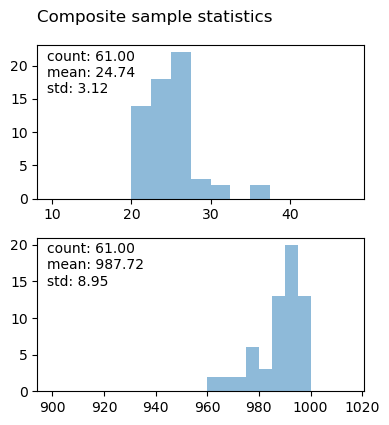

In [290]:
model_name = 'AM2.5'
experiment_name = 'CTL1990s_swishe'
year_range = (101, 125)
intensity_parameter, intensity_range = 'min_slp', (0, 1000)
field_name = 'precip'

composite_storm_samples = main(model_name, experiment_name, year_range, field_name, intensity_parameter=intensity_parameter, intensity_range=intensity_range, parallel=True)

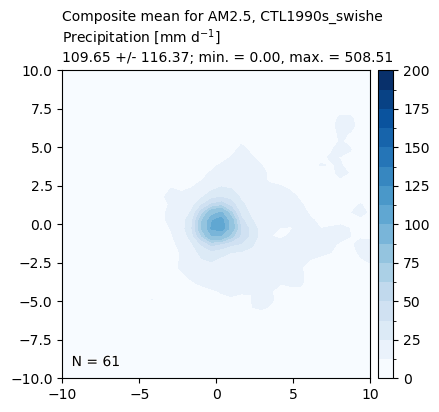

In [291]:
number_of_normalization_bins = 16
plotting_method = 'contourf'
composite_dataset = composite_storm_samples.copy()

assert plotting_method in ['contourf', 'pcolormesh'], 'Provide plotting method string that is either `contourf` or `pcolormesh`.'

number_of_samples = len(composite_dataset['storm_id'])

composite_mean = composite_dataset.mean(dim='storm_id')
composite_std = composite_dataset.std(dim='storm_id')

norm, cmap = visualization.norm_cmap(composite_mean, 
                                     field=field_name, 
                                     num_bounds=number_of_normalization_bins)

fig, ax = plt.subplots(figsize=(4, 4))

if plotting_method == 'contourf':
    im = ax.contourf(composite_mean.grid_xt_TC, composite_mean.grid_yt_TC, composite_mean, 
                     norm=norm, cmap=cmap, levels=len(norm.boundaries))
else:
    im = ax.pcolormesh(composite_mean.grid_xt_TC, composite_mean.grid_yt_TC, composite_mean, 
                       norm=norm, cmap=cmap)

# Insert annotation for sample count
sample_number_annotation = ax.annotate(f'N = {number_of_samples}', xy=(0.03, 0.03), xycoords='axes fraction', fontsize=10, ha='left', va='bottom')
sample_number_annotation.set_path_effects([pe.Stroke(linewidth=1.5, foreground='white'), pe.Normal()])
ax.set_aspect('equal')

cax = ax.inset_axes([1.025, 0, 0.05, 1])
colorbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm, cmap), cax=cax)

long_name, units = visualization.field_properties(field_name)
maximum_intensity = composite_mean.min() if field_name in ['slp', 'olr'] else composite_mean.max()
composite_statistics_string = f'{maximum_intensity:.2f} +/- {composite_std.max():.2f}; min. = {composite_dataset.min():.2f}, max. = {composite_dataset.max():.2f}'

title_string = f'Composite mean for {model_name}, {experiment_name}\n{long_name.capitalize()} [{units}]\n{composite_statistics_string}'
ax.set_title(title_string, loc='left', ha='left', fontsize=10);